In the following Jupyter notebook, we search for the $H \to \gamma \gamma$ decay process by scanning the invariant mass spectrum of many events detected in the Compact Muon Solenoid (CMS) detector. The procedure is essentially the same as what we performed before (please see "Elementary_Z0_Boson_Search_with_ROOT" for exposition about ROOT).

We first import ROOT as usual. To learn more, please visit: https://root.cern/

In [1]:
try:
    import ROOT
    import time
except ImportError as E:
    print(f"Terrible error importing ROOT: {R}")

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C x86_64-conda-linux-gnu-c++   -DNDEBUG -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0


Welcome to JupyROOT 6.24/06


Next, we obtain the data that we're working with through a hyperlink to a .root file.

In [2]:
DATA_SOURCE = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root"
datafile = ROOT.TFile.Open(DATA_SOURCE)

Now, we extract the relevant part of that data.

In [3]:
tree = datafile.Get("mini")
number_of_detections = tree.GetEntries()
print(f"The tree has {number_of_detections if number_of_detections > 50000 else 'not a shocking amount of'} detections.")

The tree has 430344 detections.


We now set up the ROOT Canvas on which we'll draw the histogram.

In [4]:
CANVAS_HEADER = "Canvas Header"
CANVAS_WIDTH = 800
CANVAS_HEIGHT = 600
canvas = ROOT.TCanvas("Canvas", CANVAS_HEADER, CANVAS_WIDTH, CANVAS_HEIGHT)

Next, we set up the histogram that we're going to draw on the ROOT Canvas.

In [5]:
HISTOGRAM_HEADER = "Higgs_to_Gamma_Gamma"
HISTOGRAM_TITLE = "Di-Photon Invariant Mass Spectrum"
HISTOGRAM_X_AXIS_LABEL = "Invariant Mass m_{yy} [GeV]"
HISTOGRAM_Y_AXIS_LABEL = "Number of Events [N]"
NUMBER_OF_BINS = 70
HISTOGRAM_LOWER_BOUND = 100
HISTOGRAM_UPPER_BOUND = 170
root_histogram = ROOT.TH1F(
    HISTOGRAM_TITLE,
    f"{HISTOGRAM_TITLE};{HISTOGRAM_X_AXIS_LABEL};{HISTOGRAM_Y_AXIS_LABEL}", 
    NUMBER_OF_BINS, 
    HISTOGRAM_LOWER_BOUND,
    HISTOGRAM_UPPER_BOUND)
print(f"Bins represent intervals of {(HISTOGRAM_UPPER_BOUND - HISTOGRAM_LOWER_BOUND) / NUMBER_OF_BINS} GeV")

Bins represent intervals of 1.0 GeV


Now, we begin the physics analysis. Photons interact with the electromagnetic calorimeter (ECAL) of the CMS detector. What is occurring in the many loops and validation processes below is the choosing and rejecting of detections based on a particular range of $\textit{pseudorapidity}$ and transverse momentum. Then, we construct the photons' 4-vectors and perform simple addition to reconstruct the particle from which the photons likely came from. Finally, we extract the mass of that particle and add it to the histogram.

In [6]:
Photon_1_4_vector = ROOT.TLorentzVector()
Photon_2_4_vector = ROOT.TLorentzVector()

LOGGING_INTERVAL = 100000

for_loop_start_time = time.time()
for index, event in enumerate(tree):
    if (index % LOGGING_INTERVAL == 0):
        print(f"Now on iteration {index}.")
    if (tree.trigP):
        list_of_good_photons_found = [0]*5
        number_of_good_photons_in_event = 0
        current_photon_index = 0
        for j in range(tree.photon_n):
            if (tree.photon_isTightID[j]):
                if (tree.photon_pt[j] > 25000 and (ROOT.TMath.Abs(tree.photon_eta[j]) < 2.37)\
                   and (ROOT.TMath.Abs(tree.photon_eta[j]) < 1.37 or ROOT.TMath.Abs(tree.photon_eta[j]) > 1.52)):
                    number_of_good_photons_in_event += 1
                    list_of_good_photons_found[current_photon_index] = j
                    current_photon_index += 1
        if(number_of_good_photons_in_event == 2):
            index_of_good_photon_1 = list_of_good_photons_found[0]
            index_of_good_photon_2 = list_of_good_photons_found[1]
            if((tree.photon_ptcone30[index_of_good_photon_1]/tree.photon_pt[index_of_good_photon_1] < 0.065)\
               and (tree.photon_etcone20[index_of_good_photon_1] / tree.photon_pt[index_of_good_photon_1] < 0.065)):
                if((tree.photon_ptcone30[index_of_good_photon_2]/tree.photon_pt[index_of_good_photon_2] < 0.065)\
                   and (tree.photon_etcone20[index_of_good_photon_2] / tree.photon_pt[index_of_good_photon_2] < 0.065)):
                    Photon_1_4_vector.SetPtEtaPhiE(tree.photon_pt[index_of_good_photon_1] / 1000., tree.photon_eta[index_of_good_photon_1],\
                                          tree.photon_phi[index_of_good_photon_1], tree.photon_E[index_of_good_photon_1] / 1000.)
                    Photon_2_4_vector.SetPtEtaPhiE(tree.photon_pt[index_of_good_photon_2] / 1000., tree.photon_eta[index_of_good_photon_2],\
                                          tree.photon_phi[index_of_good_photon_2], tree.photon_E[index_of_good_photon_2] / 1000.)
                    Reconstructed_Higgs_4_Vector = Photon_1_4_vector + Photon_2_4_vector
                    root_histogram.Fill(Reconstructed_Higgs_4_Vector.M())



for_loop_end_time = time.time()
for_loop_duration = for_loop_end_time - for_loop_start_time
print(f"Finished looping in {int(for_loop_duration / 60)} minutes and {int(for_loop_duration % 60)} seconds.")

Now on iteration 0.
Now on iteration 100000.
Now on iteration 200000.
Now on iteration 300000.
Now on iteration 400000.
Finished looping in 0 minutes and 16 seconds.


Now, let's draw the invariant mass spectrum. We'll first plot the number of events on the $y-$axis on a linear scale and then change it to logarithmic the next time we plot it.

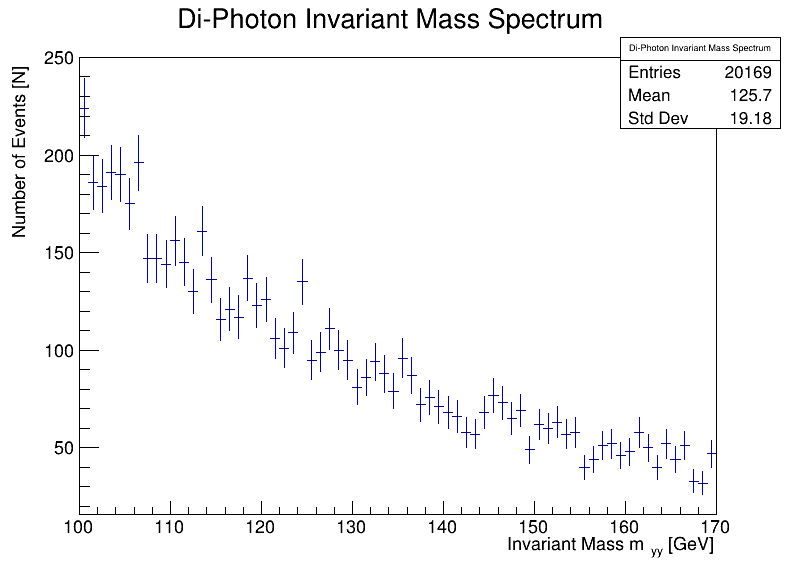

In [7]:
root_histogram.Draw("E")
canvas.Draw()

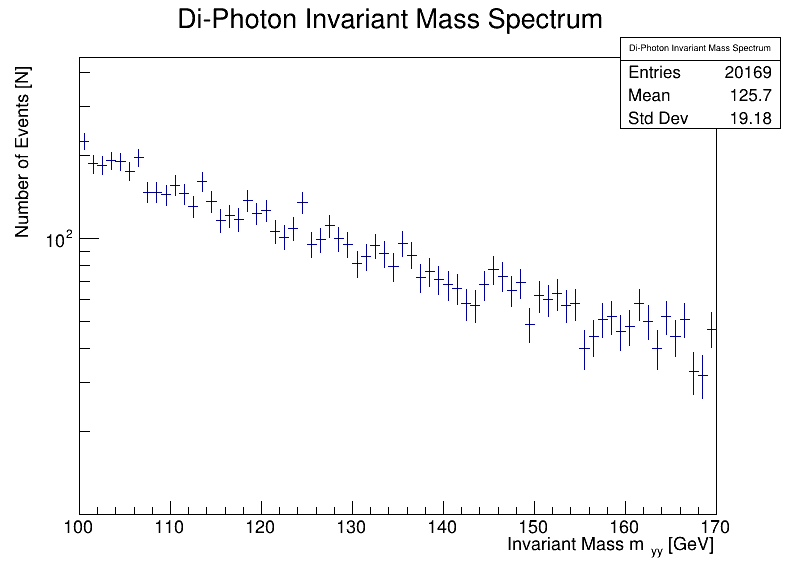

In [8]:
root_histogram.Draw("E")
root_histogram.SetMinimum(10)
canvas.SetLogy()
canvas.Draw()